# DeepSponsorBlock

## Auteurs

Johan KHA, Islaan MUHAMMAD, Yanis PERRIN, François SOULIE et Paul TISSEDRE

## Objectifs du projet

Détection de séquences sponsorisées dans une vidéo Youtube


## Imports

Nous avons commencé par créer un cellule avec tous les imports nécessaire pour le projet ainsi que les chemins d'accès pour accéder au données récupérer sur le site de youtube_dl. Les modules utilisés (présents dans le requirements.txt) sont :
- `youtube_dl` : Sont utilité était originellement  de télécharger les vidéos que nous aurions choisi. Cependant, nous nous sommes rendu compte que le module yt_dlp était une version similaire mais plus récente et mise à jour.  
- `yt_dlp` : Comme précisé ci-dessus, yt_dlp et le module le plus à jour qui permet de télécharger des vidéos youtube de manière plus efficace.  
- `numpy` : Opérations matricielles
- `pandas` : Manipulation des données
- `plotly` : Affichage de graphiques facilitant la visualisation des données 
- `matplotlib` : Utilisation similaire à pltoly mais avec des fonctions supplémentaires dont nous avons eu besoin.  
- `torch` :  
- `tqdm` :  
- `librosa` : Conversion d'un son en un spectrogramme
- `Pillow` : Traitement d'images

In [2]:
try:
    import numpy as np
    import pandas as pd
    import plotly.express as px
    import ffmpeg

    import os
    import time
    import json
    import re
    from http import client
    from urllib import parse
    from math import ceil
    from datetime import timedelta
    from datetime import datetime
    import subprocess

    import youtube_dl
    import yt_dlp
    from tqdm import tqdm

    from multiprocessing import cpu_count
    from multiprocessing.pool import ThreadPool, Pool

    from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
    from concurrent.futures import as_completed

    import matplotlib.pyplot as plt
    import librosa
    from PIL import Image

    import torch
    from torch import nn
    from torch import optim
    import torch.nn.functional as F
    from torchvision import datasets, transforms, models
    from torch.utils.data import Dataset
    
except ModuleNotFoundError:
    !pip install -r ./requirements.txt

base_dir = "/storage8To/datasets/deepsponsorblock"
data_dir = f"{base_dir}/sponsorblock"
dl_dir = f"{base_dir}/videos"

frames_dir = f"{base_dir}/images"
train_dir = f"{frames_dir}/old/train_old/"
test_dir = f"{frames_dir}/old/test_old/"

train_sponsored_dir = f"{train_dir}/sponsored"
train_not_sponsored_dir = f"{train_dir}/not_sponsored"

test_sponsored_dir = f"{test_dir}/sponsored"
test_not_sponsored_dir = f"{test_dir}/not_sponsored"

video_paths = open(f"{dl_dir}/videos.txt").read().splitlines()
db_path = f"{base_dir}/db_dsb.csv"

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

## Étude et nettoyage du dataset

### Découverte du dataset

Nous avons récupéré ce dataset à l'aide de l'extension SponsorBlock. Nous avons commencé par nous l'approprier en l'important puis en affichant ses caractéristiques  principales. On affiche notamment le nombre de na ainsi que le nombre de vidéos uniques.

In [ ]:
df=pd.read_csv(f"{data_dir}/sponsorTimes.csv") 

In [ ]:
df[df["videoID"] == "-92SZ8A0VcU"]

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.isna().sum()

In [ ]:
df.isna().sum().sum()

In [ ]:
len((df['videoID']).unique())

### Traitement

Nous avons commencé le traitement des données par la suppression des colonnes qui ne nous intéressaient pas puis nous avons uniquement conservé les vidéos contenant des parties sponsorisées.

In [ ]:
df=df.drop(['description','userAgent','UUID','incorrectVotes','actionType','service','hashedVideoID'], axis=1)
df=df.query("category=='sponsor'")
df=df.dropna(axis=0)

#### Histogrammes

Nous avons ensuite réalisé différents histogrammes qui nous ont permis de comprendre l'importance de différentes colonnes et de visualiser où se trouvait la majorité des vidéos qui pouvaient nous intéresser.

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig1 = make_subplots(rows=1, cols=2)
fig2 = make_subplots(rows=1, cols=2)
fig3 = make_subplots(rows=1, cols=2)
trace0 = go.Histogram(x=df['locked'],name='locked',)
trace1 = go.Histogram(x=np.log(df['reputation']),name='reputation',xbins=dict(
        start=-10,
        end=10
    ))
trace2 = go.Histogram(x=df['votes'],name='votes',xbins=dict(
        start=0,
        end=20
    ))
trace3 = go.Histogram(x=df['videoDuration'],name='videoDuration',xbins=dict(
        start=0,
        end=5000
    ))
trace4 = go.Histogram(x=df['hidden'],name='hidden')
trace5 = go.Histogram(x=df['shadowHidden'],name='shadowHidden')

fig1.append_trace(trace0,1,1)
fig1.append_trace(trace1,1,2)
fig2.append_trace(trace2,1,1)
fig2.append_trace(trace3,1,2)
fig3.append_trace(trace4,1,1)
fig3.append_trace(trace5,1,2)
fig1.show(renderer="iframe")

In [ ]:
fig3.show(renderer="iframe")

### Création d'une dataframe intermédiaire

On crée une data frame intermédiaire pour isoler  les vidéos qui nous intéressent en fonction de certaines catégories identifiées à l'aide des histogrammes réalisés précédemment ainsi que selon certains critères que nous avons déterminé comme importants. Par exemple, nous avons conservé les vidéos dont la durée est supérieure à 10 secondes, pour être sûr de ne pas avoir de vidéo vide, et inférieure à 1200 secondes (20 min) pour éviter que le téléchargement prenne trop de temps. Nous avons aussi par la suite gardé les vidéos dont la partie sponsorisée était supérieure à 5 secondes.

In [ ]:
df1=df.query("(videoDuration<1200 and videoDuration>10 and locked>=1 and hidden==0 and shadowHidden==0) or (videoDuration<1200 and videoDuration>10 and votes>=10 and hidden==0 and shadowHidden==0)") 
df1['sponsorDuration']=df1['endTime']-df1['startTime']
df1['percentSponsor']=df1['sponsorDuration']*100/df1['videoDuration']
df1

In [ ]:
fig2 = make_subplots(rows=1, cols=1)

trace0 = go.Histogram(x=df1['sponsorDuration'],name='sponsorDuration',)

fig2.append_trace(trace0,1,1)
#fig1.append_trace(trace6,1,1)

fig2.show()

In [ ]:
df2=df1[df1['sponsorDuration']>5]

### Création de la dataframe finale

#### Matrice d'intersection
Pour chaque séquence d'une même vidéo, on crée la matrice 2D qui décrit si la séquence d'indice i intersecte la séquence d'indice j.

In [ ]:
def matrice_intersection(df):
    n=len(df)
    matrice=np.zeros((n,n),dtype=bool)
    for i in range(n):
        for j in range(n):
            elt_st=df.startTime.iloc[i]
            elt2_st=df.startTime.iloc[j]
            elt_et=df.endTime.iloc[i]
            elt2_et=df.endTime.iloc[j]
            if abs(elt_st-elt2_st)<60 and abs(elt_et-elt2_et)<60 : #seuil de 60 secondes
                matrice[i,j]=True
    return matrice

#### Table de groupes
À partir de la matrice d'intersection, on détermine les groupes d'indices des intersections que l'on stocke dans un tableau.

In [ ]:
def group_table(matrice):
    table=[]
    for i in range(matrice.shape[0]):
        group=np.argwhere(matrice[i]).ravel().tolist()
        if group not in table:
            table.append(group)
    return table

On récupére les dataframes associées aux groupes calculés précédemment.

In [ ]:
def group_dataframe(df,table):
    return [df.iloc[table[i]] for i in range(len(table))]

#### Dictionnaire
En utilisant les dataframes, on construit le dictionnaire qui contiendra les données de la dataframe finale.

In [ ]:
def create_deepsponsorblock_row(dataframe):
    dictionnaire={
        "videoID":dataframe['videoID'].iloc[0],
        "startTime":max(dataframe['startTime']),
        "endTime":min(dataframe['endTime']),
        "startNotSure":min(dataframe['startTime']),
        "endNotSure":max(dataframe['endTime']),
        "videoDuration":dataframe['videoDuration'].iloc[0]}
    return dictionnaire

#### Dataframe finale
En assemblant les fonctions précédentes, on crée la dataframe finale.

In [ ]:
def create_deepsponsorblock_dataframe(dataframe):
    gb = dataframe.groupby('videoID') 
    group=[gb.get_group(x) for x in gb.groups]
    table_df=[]
    for element in group:
        matrice=matrice_intersection(element)
        print(matrice)
        table=group_table(matrice)
        print(table)
        df=group_dataframe(element,table)
        print(df)
        rows=[create_deepsponsorblock_row(element2) for element2 in df]
        table_df+=rows
    df_final=pd.DataFrame.from_records(table_df)
    return df_final

In [ ]:
df_final=create_deepsponsorblock_dataframe(df2)

In [ ]:
df_final

In [ ]:
#df_final.to_csv(f"{data_dir}/df_dsb.csv")

In [ ]:
df_final=pd.read_csv(f"{db_path}") 
df_final=df_final.drop(['Unnamed: 0'], axis=1)

In [ ]:
df_final.loc[0]

videoID         --DKkzWVh-E
startTime           681.162
endTime             755.183
startNotSure        681.162
endNotSure          755.183
Name: 0, dtype: object

### Création de la liste de vidéo unique à télécharger

Notre df_final contient des doublons et nous ne voulons pas télécharger 2 fois la même vidéo, c'est pour cela que l'on crée une nouvelle data frame avec toutes les vidéos uniques à partir de df_final.

In [ ]:
video_unique_dl=list(df_final['videoID'].unique())

In [ ]:
len(list(df_final['videoID'].unique()))

## Youtube-dl

L’outil permet de télécharger une vidéo youtube via une commande du type ``youtube-dl [OPTIONS] URL [URL...]``

Il existe une bibliothèque python permettant de l’utiliser dans un programme, ce que nous avons fait.

Les options sont nombreuses, mais les plus importantes dans le cadre de ce projet sont les suivantes
- ``writedescription`` : permet de télécharger la description de la vidéo en plus de son contenu
- ``writeinfojson`` : permet d'accéder aux métadonnées de la vidéo, notamment sa durée nous permettant ainsi de compléter la colone videoDuration du dataset
- ``format`` : contrôle le format du fichier téléchargé ainsi que sa qualité
- ``logger`` : permet d'indiquer à la bibliothèque un logger à utiliser 

L’outil télécharge les vidéos de façon séquentielle ce qui pose problème car le temps de téléchargement est limité par youtube à environ la durée de la vidéo. Ainsi, dans notre cas, il faut trouver un moyen de télécharger plusieurs vidéos en même temps puisque autrement le téléchargement d’une grosse quantité de vidéos sera extrêmement long.

On utilise alors la bibliothèque `multiprocessing` de Python afin d'éxecuter plusieurs batchs de téléchargements en parallèle sur différents threads.

Pour de réduire davantage le temps de téléchargement , on téléchargera aussi la vidéo dans sa qualité la plus basse possible.

### Logger

In [ ]:
ignore_starts = ["[download]", "[debug]", "[youtube]"]

class Logger:
    def __init__(self, log_file="dl_videos.logs") -> None:
        self.logfile = open(log_file, 'a')

    def debug(self, msg):
        if any([msg.startswith(x) for x in ignore_starts]):
            pass
        else:
            self.info(msg)
            

    def info(self, msg):
        pass

    def warning(self, msg):
        self.logfile.write(datetime.now().strftime("%H:%M:%S") + msg + '\n')

    def error(self, msg):
        self.logfile.write(datetime.now().strftime("%H:%M:%S") + msg + '\n')

### Téléchargement séquentiel

In [ ]:
ydl_opts = {
    'outtmpl': f'{dl_dir}/%(id)s/%(id)s.mp4',
    'format': 'worstvideo[ext=mp4][height>=480]+worstaudio[ext=m4a]',
    'ignoreerrors': 'only_download',
    'quiet': True,
    'logger': Logger()
}

def dl_videos_ytdl(urls):
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
      ydl.download(urls)
    return urls

def dl_videos(urls):
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
      ydl.download(urls)
    return urls

### Téléchargement parallèle

In [ ]:
def dl_videos_parallel(urls):
    for res in ThreadPool().imap_unordered(dl_videos, urls):
      print(f"Téléchargement de {res} fini")

def dl_videos_parallel2(urls):
  pool = ThreadPoolExecutor()
  futures = [pool.submit(dl_videos, url) for url in urls]

  for future in as_completed(futures):
    print(f"Téléchargement de {future.result()} fini")

def dl_videos_parallel3(urls):
  pool = ProcessPoolExecutor()
  futures = [pool.submit(dl_videos, url) for url in urls]

  for future in as_completed(futures):
    print(f"Téléchargement de {future.result()} fini")

### Téléchargement fragmenté

In [ ]:
!yt-dlp --downloader ffmpeg -N 25 -a $urls_list -o "$dl_dir/%(id)s/%(id)s.mp4" -f "worstvideo[ext=mp4]+worstaudio[ext=m4a]" --write-description -q

### Comparaison

In [ ]:
urls = open(urls_list).readlines()

# !rm -rf $dl_dir/*

# t0 = time.time()
# dl_videos(urls)
# t_seq = time.time() - t0

!rm -rf $dl_dir/*

t1 = time.time()
dl_videos_parallel(urls)
t_par1 = time.time() - t1

!rm -rf $dl_dir/*

t2 = time.time()
dl_videos_parallel2(urls)
t_par2 = time.time() - t2

!rm -rf $dl_dir/*

t3 = time.time()
!yt-dlp --downloader ffmpeg -N 25 -a $urls_list -o "$dl_dir/%(id)s/%(id)s.mp4" -f "worstvideo[ext=mp4]+worstaudio[ext=m4a]" --write-description -q
t_frag = time.time() - t3

# !rm -rf $dl_dir/*

# t4 = time.time()
# dl_videos_ytdl(urls) # ~10 minutes pour 10 videos
# t_ytdl = time.time() - t4

!rm -rf $dl_dir/*

t5 = time.time()
dl_videos_parallel3(urls)
t_par3 = time.time() - t5

print(f"Temps parallele 1: {t_par1}", f"Temps parallele 2: {t_par2}", f"Temps parallele 3: {t_par3}", f"Temps fragmenté: {t_frag}")

### Filtrage des vidéos selon leurs durée

Afin d'éviter de télécharger des vidéos trop longues, on utilise l'option `youtube-dl` permettant justement de filtrer les vidéos.

In [ ]:
def dl_videos_length_filter(info_dict, *, incomplete):
    duration = info_dict.get("duration")

    if duration and duration > 20 * 60:
        "La video est trop longue"

def dl_videos(urls):
    t_start = time.time()

    with yt_dlp.YoutubeDL({**ydl_opts, **{'match_filter': dl_videos_length_filter}}) as ydl:
        info = ydl.extract_info(urls, download=True)
        desc = info.get("description") if info else None

        if desc:
            description.save_description_parsed_urls(desc, f"{paths.DL_DIR}/{info['id']}/{info['id']}.desc.json")
    
    t_end = time.time()

    return urls, t_end - t_start

### Traitement des descriptions

On souhaite détecter les URLs présents dans la description des vidéos, pour ensuite les extraire et idéalement déterminer l'url sponsorisé. Ce procédé contient 3 étapes.

1. Détection de l'URL
2. Traduction de l'URL si il est raccourci
3. Parsing de l'URL pour extraire ses paramètres

#### Détection de l'URL

On utilise l'expression régulière suivante afin de détecter les URLs

``https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&\/=]*)
``

In [ ]:
exp = r"https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&\/=]*)"

def find_urls(text):
  return re.findall(exp, text)

#### Traduction de l'URL

In [ ]:
def unshorten_url(url):
    parsed = parse.urlparse(url)
    h = client.HTTPConnection(parsed.netloc)
    resource = parsed.path

    if parsed.query != "":
        resource += "?" + parsed.query
    if parsed.netloc == "":
        return None

    h.request('HEAD', resource)
    response = h.getresponse()

    if response.status//100 == 3 and response.getheader('Location') != url:
        return unshorten_url(response.getheader('Location'))
    else:
        return url

#### Parsing de l'URL

Le parsing de l'url peut être fait avec la fonction ``urlparse(url)`` du module ``parse``

#### Extraction des données obtenues

Il est ensuite nécéssaire d'extraire les données obtenues grâce à ce traitement et des les écrire dans un fichier.

In [ ]:
def get_description_parsed_urls(description):
  urls = find_urls(description)
  t_urls = [unshorten_url(url) for url in urls]
  parsed_urls = [
      {
          "url": url,
          "parsed": parse.urlparse(url)
      }
      for url in t_urls if url is not None
  ]

  return parsed_urls

def save_description_parsed_urls(description, out_path):
  parsed_urls = get_description_parsed_urls(description)
  with open(out_path, "w") as file:
    json.dump(parsed_urls, file, indent=4)

### Téléchargement

In [ ]:
def dl_videos_parallel(urls):
    tasks_completed = 0
    tasks_total = len(urls)

    with tqdm(total=tasks_total) as pbar:
        with ProcessPoolExecutor(5) as pool:
            futures = [pool.submit(dl_videos, url) for url in urls]

            for res in as_completed(futures):
                res.result()
                pbar.update(1)

    return tasks_completed

df = pd.read_csv(db_path)
urls = list(df['videoID'].unique())

print(f"Il y a {len(urls)} videos à télécharger")
print("Téléchargement en cours...")

videos.dl_videos_parallel(urls)

## Création du dataset via l'extraction des images des vidéos

### Utilisation d'OpenCV

Afin de rester dans l'environnement Python, nous avons étudié la possibilité d'utiliser `opencv` afin d'extraire les images des vidéos. Un résultat fonctionnel ressemblerait au code ci-dessous. Malheureusement, `opencv` est incapable de traiter les vidéos encodée en format `AV1`, le format utilisé par `youtube-dl`. La convertion du format des 20e3 vidéos est possible mais aurait une durée extrêmement longue, bien plus que le téléchargement.

In [ ]:
import cv2

def get_video_frames(path: str, t_range: "tuple[int, int]", step: int = 1) -> "list":
    vidcap = cv2.VideoCapture(path)
    frame_total = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

    for t in range(0, frame_total, step):è
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, t)
        res, frame = vidcap.read()
        yield frame

### Utilisation de ffmpeg

On décide alors d'utiliser ffmpeg directement dans Python, puisque cet outil peut lui traiter tous les formats.

In [ ]:
def get_video_frames(name: str, path: str, t_range: "tuple[int, int]", fps: int = 1) -> "list":
    duration = get_video_duration(path)

    if t_range[0] < 0 or t_range[1] > duration or t_range[0] > t_range[1]:
        raise Exception("Invalid time range values")

    cmd = f"ffmpeg -ss {t_range[0]} -t {t_range[1]} -i {p} -r {fps} -f image2 {name}-%03d.bmp"
    subprocess.run(cmd.split(" "))

Cette méthode fonctionne mais semble peu flexible puisqu'on invoque `ffmpeg` directement. Il existe une bibliothèque Python `ffmpeg-python` permettant d'abstraire l'utilisation de l'outil.

In [ ]:
def extract_n_frames(in_path: str, out_path: str, t_range: "tuple[int, int]", n_frames):
    assert os.path.exists(in_path)
    assert t_range[0] >= 0 and t_range[1] >= t_range[0]

    duration = int(t_range[1] - t_range[0])
    rate = 1/(duration/n_frames)

    ss = str(timedelta(seconds=t_range[0]))
    to = str(timedelta(seconds=t_range[1]))

    in_file = ffmpeg.input(in_path, ss=ss, to=to)
    (
        in_file
        .filter("fps", fps=rate)
        .output(out_path)
        .overwrite_output()
        .run()
    )
    
def extract_dfrange_frames(paths: "list[str]", df: pandas.DataFrame, range_columns: "tuple[str|None, str|None]", out_dir: str, n_frames: int):
    assert "videoID" in df.columns
    assert not all([x is None for x in range_columns])
    assert all([x is None or x in df.columns for x in range_columns])

    for path in paths:
        p, _ = os.path.splitext(path)
        id = os.path.basename(p)

        rows = df[df["videoID"] == id]

        if len(rows) > 0:
            row = rows.iloc[0]
            start = int(row[range_columns[0]]) if range_columns[0] is not None else 0
            end = int(row[range_columns[1]]) if range_columns[1] is not None else float(ffmpeg.probe(path)["format"]["duration"])

            extract_n_frames(path, os.path.join(out_dir, f"{id}_{n_frames}_{end-start}_%04d.jpg"), (start, end), n_frames)

Cette fois-ci, la méthode `extract_n_frames` fonctionne parfaitement. Cependant, elle est plutôt lente car même si on souhaite extraire par exemple 10 frames dans un interval de 20 secondes dans une vidéo, `ffmpeg` traite la vidéo entière puis extrait les frames demandées.
Une solution à ce problème qui a première vue semblait non optimale est d'incrémenter une variable `step` d'un timecode `A` à un timecode `B` et d'extraire une seule frame à chaque fois avec un nouveau processus `ffmpeg`.

In [ ]:
def extract_n_frames(in_path: str, out_dir: str, t_range: "tuple[int, int]", n_frames):
    assert os.path.exists(in_path)
    assert t_range[0] >= 0 and t_range[1] >= t_range[0]

    duration = int(t_range[1] - t_range[0])
    step = ceil(duration/n_frames)

    if step <= 0:
        return

    p, _ = os.path.splitext(in_path)
    id = os.path.basename(p)

    for k in range(int(t_range[0]), int(t_range[1]), step):
        ss = str(timedelta(seconds=k))

        in_file = ffmpeg.input(in_path, ss=ss)
        (
            in_file
            .output(os.path.join(out_dir, f"{id}_{k}.jpg"), vframes=1)
            .overwrite_output()
            .run(quiet=True)
        )

def extract_dfrange_frames(path: str, df: pd.DataFrame, range_columns: "tuple[str|None, str|None]", out_dir: str, n_frames: int):
    assert "videoID" in df.columns
    assert not all([x is None for x in range_columns])
    assert all([x is None or x in df.columns for x in range_columns])

    p, _ = os.path.splitext(path)
    id = os.path.basename(p)

    rows = df[df["videoID"] == id]

    if len(rows) > 0:
        row = rows.iloc[0]
        start = int(row[range_columns[0]]) if range_columns[0] is not None else 1
        end = int(row[range_columns[1]]) if range_columns[1] is not None else float(ffmpeg.probe(path)["format"]["duration"])

        extract_n_frames(path, out_dir, (start, end), n_frames)

def extract_sponsored_frames(path: str, df: pd.DataFrame, out_dir: str, n_frames):
    extract_dfrange_frames(path, df, ("startTime", "endTime"), out_dir, n_frames)

def extract_not_sponsored_frames(path: str, df: pd.DataFrame, out_dir: str, n_frames):
    extract_dfrange_frames(path, df, (None, "startNotSure"), out_dir, n_frames//2)
    extract_dfrange_frames(path, df, ("endNotSure", None), out_dir, n_frames//2)

def extract_frames(path: str, df: pd.DataFrame, out_dir_sponsored: str, out_dir_not_sponsored: str, n_frames):
    extract_sponsored_frames(path, df, out_dir_sponsored, n_frames)
    extract_not_sponsored_frames(path, df, out_dir_not_sponsored, n_frames)

Cette méthode est satisfaisante. Cependant à l'avenir si `opencv` est mis à jour pour support le format `AV1`, nous abandonnerons sûrement `ffmpeg` pour cette bibliothèque bien plus pratique à utiliser.

### Extraction des images d'entraînement

In [ ]:
df = pd.read_csv(db_path)

with tqdm(total=len(video_paths[:1000])) as pbar:
    for path in video_paths[:1000]:
      try:
        extract_frames(path, df, train_sponsored_dir, train_not_sponsored_dir, 20)
        pbar.update(1)
      except AssertionError:
        pbar.update(1)
        continue

### Extraction des images de test

In [ ]:
df = pd.read_csv(db_path)

with tqdm(total=len(video_paths[100:200])) as pbar:
    for path in video_paths[100:200]:
      try:
        extract_frames(path, df, test_sponsored_dir, test_not_sponsored_dir, 10)
        pbar.update(1)
      except AssertionError:
        pbar.update(1)
        continue

### Extraction des  audios en image (spectogramme) 

In [ ]:
def get_audio_frame(in_path, out_path, time, window):
    y, sr = librosa.load(in_path)
    
    starty = (time-window) * sr
    endy = (time+window) * sr
    y2 = y[starty:endy]
    
    S = librosa.feature.melspectrogram(y=y2, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    S_dB = S_dB.astype(np.uint8)
    
    im = Image.fromarray(S_dB)
    im.save(out_path)

## Entraînement IA

#### Transfer Learning

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

print(train_data[0][0].size())

batch_size = 128

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

print(next(iter(trainloader))[0].size())

In [ ]:
# Use GPU if it's available
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

model.to(device);

In [ ]:
for param in model.parameters():
    param.requires_grad = True

epochs = 25
steps = 1
running_loss = 0
print_every = 5

print(os.environ["CUDA_VISIBLE_DEVICES"])

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
                    # print("top_class", top_class)
                    # print("labels.view", labels.view(*top_class.shape))
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

### Traitement de séquences

#### Modification du modele

In [84]:
class SuperModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = models.resnet18(pretrained=True)
        self.encoder.fc = nn.Identity()
        self.classifier = nn.Sequential(
            nn.Conv1d(512, 256, 3),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 128, 3),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 64, 3),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 1, 3)
        )

    def forward(self, x):
        # (batch_size, seq_length, n_channels:3, H:224, W:224)
        x = x.float()
        out = []
        for inp in x:
            h_i = self.encoder(inp)
            out.append(h_i.T.unsqueeze(0))
        reps = torch.cat(out, dim=0)
        out = self.classifier(reps)
        return out.squeeze(1)

#### Chargement des données

In [127]:
def get_t_ranges(df: pd.DataFrame, idx: int):
    assert all([x in df.columns for x in ["videoID", "startTime", "endTime", "startNotSure", "endNotSure"]])
    
    if idx in df.index:
        data = df.iloc[idx]
                
        return {
            "sponsored": (int(data["startTime"]), int(data["endTime"])),
            "not_sponsored": (0, int(data["startNotSure"]))
        }

def get_images(in_path, t_range, width, height, length=10, fps="2/1"):
    assert os.path.exists(in_path)

    out, err = (
        ffmpeg.input(in_path, ss=t_range[0], to=t_range[1])
        .filter("scale", width, height)
        .filter("fps", fps=fps)
        .output("pipe:", format="rawvideo", pix_fmt="rgb24", vframes=length)
        .run(capture_stdout=True, quiet=True)
    )

    frames = np.frombuffer(out, np.uint8).reshape([-1, height, width, 3])
    
    return np.moveaxis(frames, -1, 1) # Move channel axis to first dimension

class DSBDataset(Dataset):
    def __init__(self, infos_df, video_paths, seq_length, img_path, transform=None, target_transform=None):
        self.infos_df = infos_df
        self.video_paths = video_paths
        self.seq_length = seq_length
        self.transform = transform
        self.target_transform = target_transform
        self.img_path = img_path
        
    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, index):
        p, _ = os.path.splitext(self.video_paths[index // 2])
        id = os.path.basename(p)
        
        df_idx = self.infos_df.index[df["videoID"] == id].tolist()[0]
        t_range = get_t_ranges(self.infos_df, df_idx)
        
        item_class = "sponsored" if index%2 == 0 else "not_sponsored"
        cache_path = f"{self.img_path}/cache/{item_class}/{id}/{id}_{self.seq_length}.npy"

        # Caching
        if os.path.exists(cache_path):
            extracted_images = np.load(cache_path)
        else:
            os.makedirs(os.path.split(cache_path)[0])
            extracted_images = get_images(
                self.video_paths[index // 2],
                (t_range[item_class][0], t_range[item_class][1]),
                640, 360
            )
            np.save(cache_path, extracted_images)

        label = index%2
        
        if self.transform:
            extracted_images = [self.transform(x) for x in extracted_images]
        if self.target_transform:
            label = self.target_transform(label)
        
        tensor = torch.tensor(extracted_images)

        return tensor, label

#### Entrainement

In [131]:
batch_size = 5

df = pd.read_csv(db_path)
df = df[(df["endTime"] - df["startTime"] > 10) & (df["startNotSure"] > 10)].reset_index(drop=True)

print(len(video_paths))
video_paths = [x for x in video_paths if len(df[df["videoID"] == os.path.basename(os.path.splitext(x)[0])]) > 0]
print(len(video_paths))

train_data = DSBDataset(df, video_paths[:-3000], 10, frames_dir)
test_data = DSBDataset(df, video_paths[-1000:], 10, frames_dir)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

16882
16882


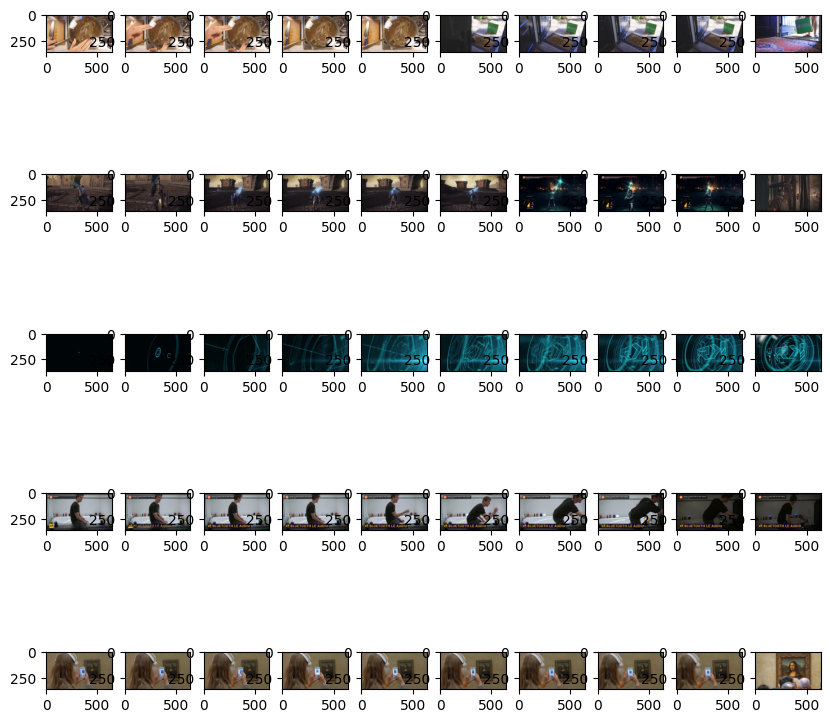

tensor([0, 1, 1, 1, 1])


In [133]:
t = next(iter(trainloader))

fig = plt.figure(figsize=(10, 10))

for i, batch in enumerate(t[0]):
    for j, img in enumerate(batch, 1):
      fig.add_subplot(5, 10, i*10 + j)
      plt.imshow(torch.moveaxis(img, 0, 2))

plt.show()
print(t[1])

In [136]:
# Use GPU if it's available
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = SuperModel()

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 1),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

model.to(device);

/home/deepsponsorblock/testenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deepsponsorblock/testenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [137]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

for param in model.parameters():
    param.requires_grad = True

epochs = 25
steps = 0
running_loss = 0
print_every = 5

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        print(f"steps={steps}")
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
                
        loss = criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            print("---TEST & TRAINING---")
            test_loss = 0
            accuracy = 0
            model.eval()
            
            with torch.no_grad():
                k = 0
                for test_inputs, test_labels in testloader:
                    k+=1
                    print(f"TRAIN k={k}")
                    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
                    logps = model.forward(test_inputs)
                    batch_loss = criterion(logps, test_labels)
                    
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == test_labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

steps=1
torch.Size([5, 10, 3, 360, 640])


RuntimeError: cuDNN error: CUDNN_STATUS_ALLOC_FAILED